## Пример: House Sales in King County, USA <a name="house_case"></a>

Будем пробовать различные методы, чтобы научиться определять цену на недвижимость.  
Данные взяты с [одноименного соревнования](https://www.kaggle.com/harlfoxem/housesalesprediction) на Kaggle.  

Данные содержат информацию о продажах индивидуальных домов в период с мая 2014 года по май 2015 в округе Кинг, штат Вашингтон, США.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
style.use('seaborn')

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

pd.set_option('display.max_columns', 25)

In [5]:
house_data = pd.read_csv("kc_house_data.csv")

Давайте сымитируем ситуацию, когда заказчик скрыл часть данных.

In [6]:
holdout = house_data.sample(2000) # рандомная скрытая часть
house_data = house_data.loc[~house_data.index.isin(holdout.index)] #наш датасет без скрытой части

И будем дальше работать с house_data, как будто части holdout у нас никогда не было

In [7]:
house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


### Комментарии по признакам

__price__ - целевая переменная (y).

__id__ - уникален для каждого объекта, необходимо удалить из выборки.

Посмотрим еще на три признака: 
* __sqft_living__ - общая площадь дома
* __sqft_above__ - общая площадь наземной части дома
* __sqft_basement__ - общая площадь подземного части дома  
  
Здравый смысл нам подсказывает, что эти признаки линейно связаны, а именно:  
$$sqft\_basement = sqft\_living - sqft\_above$$
  

In [8]:
print(house_data.sqft_basement == (house_data.sqft_living - house_data.sqft_above))

0        True
1        True
2        True
3        True
4        True
         ... 
21608    True
21609    True
21610    True
21611    True
21612    True
Length: 19613, dtype: bool


Поэтому признак sqft_basement можно удалить, оставив остальные два.

Признаки **lat** и **long** неоднозначные, но оставим их - вдруг помогут учесть географическое расположение домов. 

In [9]:
house_data[['lat', 'long']].describe()

,lat,long
count,19613.000000,19613.000000
mean,47.560281,-122.213490
std,0.138404,0.140949
min,47.155900,-122.519000
25%,47.471400,-122.328000
50%,47.572000,-122.229000
75%,47.678000,-122.124000
max,47.777600,-121.315000


### Предобработка данных

Удалим явным образом не подходящие признаки.

In [10]:
data = house_data.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)

## Обучающая и тестовая выборки <a name="train_test"></a>

Для тестирования для начала применим простой метод - разделите датасет на две части: на одной будем обучать, на другой оценивать качество модели.  


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
y = data['price']
X = data.iloc[:,1:] # оставили все колонки без price

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

## K Nearest Neighbors <a name="knn"></a>

Будем обучаться на данных X_train. Нормализуйте X_train и добавьте KNeighborsRegressor с параметром n_neigbors = 5. Посчитайте чему равна MSE.

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


reg = make_pipeline (
    KNeighborsRegressor(n_neighbors=5)
)

X_train = MinMaxScaler().fit_transform(X_train)

reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
print(mse)

19599848194.079357


Теперь в цикле подберите переберите параметр n_neigbors и по графику ошибок mse определите оптимальное значение

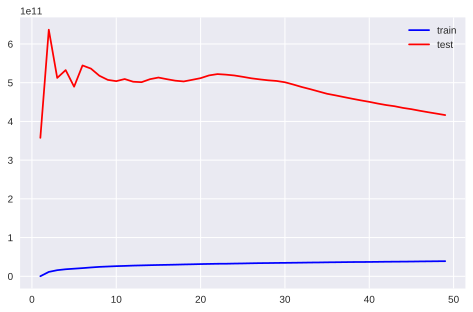

In [20]:
neighbors = range(1, 50)
errors_train = []
errors_test = []

for k in neighbors:
    neigh = KNeighborsRegressor(k).fit(X_train, y_train)
    y_train_pred = neigh.predict(X_train)
    y_test_pred = neigh.predict(X_test)
    errors_train.append(mean_squared_error(y_train, y_train_pred))
    errors_test.append(mean_squared_error(y_test, y_test_pred))
    
    
plt.plot(neighbors, errors_train, color='blue', label='train')
plt.plot(neighbors, errors_test, color='red', label='test')
plt.legend()


Оптимальным значением будет 5

Постройте такой же график, только для median_absolute_error. Совпадают ли оптимальные значения n_neigbors для 2 типов ошибок?

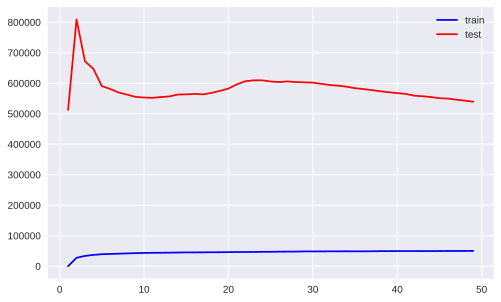

In [21]:
from sklearn.metrics import median_absolute_error

neighbors = range(1, 50)
errors_train = []
errors_test = []

for k in neighbors:
    neigh = KNeighborsRegressor(k).fit(X_train, y_train)
    y_train_pred = neigh.predict(X_train)
    y_test_pred = neigh.predict(X_test)
    errors_train += [median_absolute_error(y_train, y_train_pred)]
    errors_test += [median_absolute_error(y_test, y_test_pred)]
    
    
plt.plot(neighbors, errors_train, color='blue', label='train')
plt.plot(neighbors, errors_test, color='red', label='test')
plt.legend()

Оптимальным будет также значением 5

## Подбор k на кросс-валидации

Теперь с помощью GridSearchCV (cv=5) переберите параметр n_neighbors еще раз и выведите best_score_ и best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

param_grid = {
    'n_neighbors': range(1, 50)
}

grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    return_train_score=True,
    cv=5
)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

0.7741488404850034
{'n_neighbors': 6}


Теперь посомотрим как менялась ошибка на обучающей и тестовой части по время обучения, нарисуйте на графике 2 кривые  grid_search.cv_results_['mean_train_score'] и grid_search.cv_results_['mean_test_score']

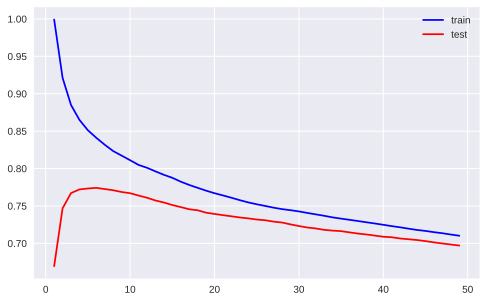

In [ ]:
plt.plot(range(1, 50), grid_search.cv_results_['mean_train_score'], color='blue', label='train')
plt.plot(range(1, 50), grid_search.cv_results_['mean_test_score'], color='red', label='test')
plt.legend()

Теперь попробуем перебрать все возможные параметры KNeighborsRegressor. Добавьте в param_grid переменные kneighborsregressor__weights,
kneighborsregressor__metric(почитайте в документации какие значения она может принимать). Выведите best_score_ и best_params_


In [ ]:
param_grid = {
    'n_neighbors': range(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowsky', 'wminkowski', 'seuclidean', 'mahalanobis']
}

grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    return_train_score=True,
    cv=5
)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

# считается очень долго

0.7913177606313093
{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


И наконец последний этап, контрольная проверка. Вспомним что у нас была скрытая выборка holdout. Теперь c ней нужно проделать те же преобразования, что и c обучающей выборкой - удалить лишние колонки, а потом применить grid_search.best_estimator_.predict) - получим предсказанные цены на скрытой части данных. 

In [ ]:
holdout_new = holdout.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)
holdout_new_y = holdout_new['price']
holdout_new_X = holdout_new.iloc[:,1:]

holdout_new_X = MinMaxScaler().fit_transform(holdout_new_X)
holdout_pred = grid_search.best_estimator_.predict(holdout_new_X)

Остается только сравнить предсказания с истинными значениями holdout['price'] и вывести mse. 

In [ ]:
print(mean_squared_error(holdout_new_y, holdout_pred))
print(grid_search.best_score_)

27773196547.998203
0.7913177606313093


Если модель обучилась хорошо, то ошибка на holdout выборке будет примерно равна ошибка на нашей собственной тестовой части, т.е. grid_search.best_score_

## Дополнительное задание для любознательных

Повторите последний этам обучения gridsearch, в param_grid подставьте только по одному оптимальному значению из grid_search.best_params_, а вместо cv = 5 подставьте cv = LeaveOneOut(). Засеките время работы алгоритма.
Улучшился ли результат?

In [ ]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

In [ ]:
from time import time

param_grid = {
    'n_neighbors': [grid_search.best_params_['n_neighbors']],
    'weights': [grid_search.best_params_['weights']],
    'metric': [grid_search.best_params_['metric']]
}

grid_search_new = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    return_train_score=True,
    cv=LeaveOneOut()
)

t = time()
grid_search_new.fit(X_train, y_train)
print(time() - t)

print(grid_search_new.best_score_)
print(grid_search_new.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


KeyboardInterrupt: ignored